In [151]:
import numpy as np
import matplotlib.pyplot as plt
import math

pi=np.pi
deg2rad=pi/180
rad2deg=1/deg2rad

We obtain the data1 from the website http://vo.imcce.fr/insola/earth/online/earth/online/index.php also linked to on absalon

We obtain the data2 from the website https://www.ncei.noaa.gov/pub/data/paleo/climate_forcing/orbital_variations/insolation/ where the data from the Berger paper sited in the paper is found. We also slice the data from 875 kyrs ago (at the insolation minimum mentioned in the paper) until present

In [152]:
data1 = np.genfromtxt('orbital_data.txt')
time_data1 = data1[:, 0] # in Julian yrs = 365.25 days
ecce_data1 = data1[:, 1]
prec_data1 = data1[:, 2]
obli_data1 = data1[:, 3]
inso_data1 = data1[:, 4]

S1 = slice(125, 1001) # slice the data from 875 kyrs ago (insolation minimum) until present 
data1 = data1[S1]; time_data1 = time_data1[S1]; inso_data1 = inso_data1[S1]; ecce_data1 = ecce_data1[S1]; obli_data1 = obli_data1[S1]; prec_data1 = prec_data1[S1]

data2 = np.genfromtxt('berger_orbital_data.txt', skip_header=2)[::-1]
time_data2 = data2[:, 0]
ecce_data2 = data2[:, 1]
obli_data2 = data2[:, 3]    
prec_data2 = data2[:, 4]
inso_data2 = data2[:, 5]

S2 = slice(4125, 5001) # slice the data from 875 kyrs ago (insolation minimum) until present 
data2 = data2[S2]; time_data2 = time_data2[S2]; inso_data2 = inso_data2[S2]; ecce_data2 = ecce_data2[S2]; obli_data2 = obli_data2[S2]; prec_data2 = prec_data2[S2]


(0.0, 875.0)

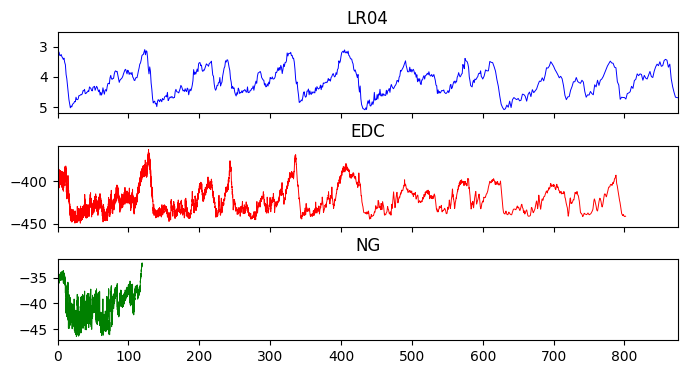

In [153]:
LR04record = np.genfromtxt('LR04record.txt')
LR04_time = LR04record[:,0]/1000
LR04_iso = LR04record[:,1]

EDCrecord = np.genfromtxt('EDCrecord.txt')
EDC_time = EDCrecord[:,0]/1000
EDC_iso = EDCrecord[:,1]

NGrecord = np.genfromtxt('NGrecord.txt')
NG_time = NGrecord[:,0]/1000
NG_iso = NGrecord[:,1]


gs = dict(hspace=0.4)
fig, axs = plt.subplots(3,1, figsize=(8, 4), sharex=True, gridspec_kw = gs)
axs[0].set_title('LR04')
axs[0].plot(LR04_time, LR04_iso, 'b', lw=0.7)
axs[0].set_ylim(axs[0].get_ylim()[::-1])

axs[1].set_title('EDC')
axs[1].plot(EDC_time, EDC_iso, 'r', lw=0.7)
# axs[1].set_ylim(-0.05, 0.1)

axs[2].set_title('NG')
axs[2].plot(NG_time, NG_iso, 'g', lw=0.7)
# axs[2].set_ylim(-0.05, 0.1)
axs[2].set_xlim(0, 875)

# fig.tight_layout()

We normalize the insolation as in the paper by paillard to have mean 0 and unity variance. We do this by subtracting the mean $\mu$ from all the $N$ data points, and then dividing everything by the standard deviation $$\sigma = \sqrt{\frac{\sum (X - \mu)^2}{N}}$$

In [154]:
def normalize(data):
    mean = np.mean(data)
    std = np.sqrt(np.sum((data - mean)**2)/len(data))
    data -= mean
    data = data/std
    return data

In [155]:
inso_data1 = normalize(inso_data1)
inso_data2 = normalize(inso_data2)

Let's plot

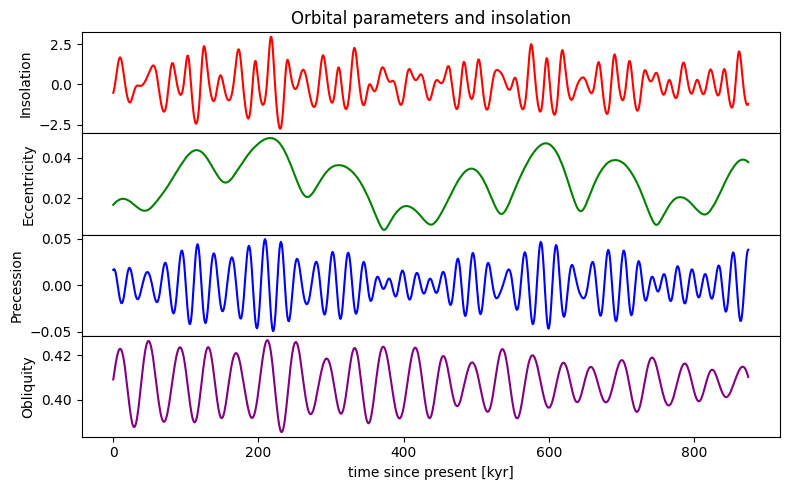

In [156]:
gs = dict(hspace=0)
fig, axs = plt.subplots(4, 1, figsize=(8,5), sharex=True, gridspec_kw = gs)
axs[0].set_title('Orbital parameters and insolation')
axs[0].plot(-time_data1, inso_data1, 'r', label = 'Insolation')
axs[0].set_ylabel('Insolation')
axs[1].plot(-time_data1, ecce_data1, 'g', label = 'Eccentricity')
axs[1].set_ylabel('Eccentricity')
axs[2].plot(-time_data1, prec_data1, 'b', label = 'Precession')
axs[2].set_ylabel('Precession')
axs[3].plot(-time_data1, obli_data1, 'purple', label = 'Obliquity')
axs[3].set_ylabel('Obliquity')
axs[3].set_xlabel('time since present [kyr]')

fig.tight_layout()


In [157]:
# Function that calculates the truncation function for the forcing
def f(x, a = 1):
    f = 1/2 * (x + np.sqrt(4 * a**2 + x**2))
    return f

In [158]:
def update_state_model1(time_since_state_change, insolation, previous_insolation, old_state, i0, i1, i2, i3, tg):
    new_state = old_state
    #i to g transition if insolation is less than i3 and the previous insolation was greater than i3
    if old_state == 2 and insolation < i3 and previous_insolation > i3:
        new_state = 1
    #g to G transition if the time since last state change is greater than ice sheet growth time tg AND if the insolation is less than i2
    elif old_state == 1 and time_since_state_change > tg and insolation < i2 and previous_insolation >= i2:
        new_state = 0
    # G to i transition if the insolation is above i1
    elif old_state == 0 and insolation > i1:
        new_state = 2
    return new_state

def paillard_model1(time_data, inso_data, init_state, i0, i1, i2, i3, tg):
    state_array = np.array([]) #Empty array to hold the climate states
    state_array = np.append(state_array, init_state)
    
    t_steps = len(time_data) # How many time steps to loop over

    time_since_state_change = 0 
    old_state = init_state #setting the initial_state
    for i in range(1, t_steps): #loop over all but one time step since we appended the initial state and the sizes of the data for plotting will get messy
        insolation = inso_data[i]
        previous_insolation = inso_data[i - 1]
        new_state = update_state_model1(time_since_state_change, insolation, previous_insolation, old_state, i0, i1, i2, i3, tg) #update the model state given the model parameters
        state_array = np.append(state_array, new_state)
        
        time_since_state_change += 1 #increment time since last change 
        if old_state != new_state: #check whether the state was changed and set the time accordingly
            time_since_state_change = 0
        
        old_state = new_state #resetting for new loop
    return state_array

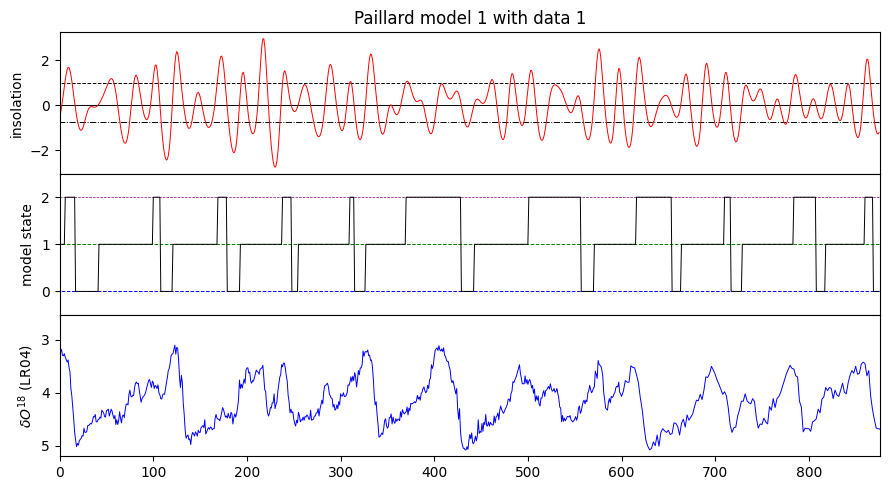

In [159]:
import scipy as sp
init_state = 0; i0=-0.75; i1=0; i2=0; i3=1; tg=33


states = paillard_model1(time_data1, inso_data1, init_state, i0, i1, i2, i3, tg)

gs = dict(hspace=0)
fig, axs = plt.subplots(3,1, figsize = (9, 5), sharex=True, gridspec_kw = gs)

Os = np.zeros_like(time_data1)

axs[0].set_title('Paillard model 1 with data 1')
axs[0].plot(-time_data1, Os + i3, 'k--', lw=0.7, label = f'i3 = {i3}')
axs[0].plot(-time_data1, Os + i1, 'k-', lw=0.7, label = f'i1 = i2 = {i1}')
axs[0].plot(-time_data1, Os + i0, 'k-.', lw=0.7, label = f'i0 = {i0}')
axs[0].plot(-time_data1, inso_data1, 'r', lw=0.7)
axs[0].set_ylabel('insolation')
# axs[0].legend()

axs[1].plot(-time_data1, Os + 2, 'purple', ls ='--', lw=0.5, label='i')
axs[1].plot(-time_data1, Os + 1, 'g--', lw=0.7, label='g')
axs[1].plot(-time_data1, Os + 0, 'b--', lw=0.7, label='G')
axs[1].plot(-time_data1, states, 'k', lw=0.7)
axs[1].set_xlabel('time since present [kyr]')
axs[1].set_ylabel('model state')
axs[1].set_xlim(0,len(time_data1))
axs[1].set_ylim(-0.5, 2.5)
# axs[1].legend()

axs[2].set_ylabel('$\delta O^{18}$ (LR04)')
axs[2].plot(LR04_time, LR04_iso, 'b', lw=0.7, label='LR04')
axs[2].set_ylim(axs[2].get_ylim()[::-1])
# axs[2].legend()

# axs[3].set_title('EDC')
# axs[3].plot(EDC_time, EDC_iso, 'r', lw=0.7, label='EDC')
# # axs[3].legend()

# fig.legend()
fig.tight_layout()
fig.savefig('paillard_model1_data1.png')

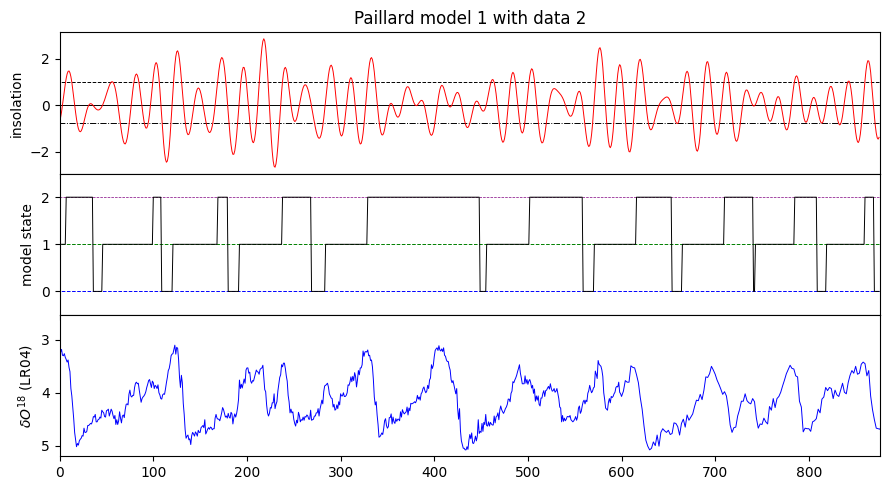

In [160]:
init_state = 0; i0=-0.75; i1=0; i2=0; i3=1; tg=33
states = paillard_model1(time_data2, inso_data2, init_state, i0, i1, i2, i3, tg)

gs = dict(hspace=0)
fig, axs = plt.subplots(3,1, figsize = (9, 5), sharex=True, gridspec_kw = gs)

Os = np.zeros_like(time_data2)

axs[0].set_title('Paillard model 1 with data 2')
axs[0].plot(-time_data2, Os + i3, 'k--', lw=0.7, label = f'i3 = {i3}')
axs[0].plot(-time_data2, Os + i1, 'k-', lw=0.7, label = f'i1 = i2 = {i1}')
axs[0].plot(-time_data2, Os + i0, 'k-.', lw=0.7, label = f'i0 = {i0}')
axs[0].plot(-time_data2, inso_data2, 'r', lw=0.7)
axs[0].set_ylabel('insolation')
# axs[0].legend()

axs[1].plot(-time_data2, Os + 2, 'purple', ls ='--', lw=0.5, label='i')
axs[1].plot(-time_data2, Os + 1, 'g--', lw=0.7, label='g')
axs[1].plot(-time_data2, Os + 0, 'b--', lw=0.7, label='G')
axs[1].plot(-time_data2, states, 'k', lw=0.7)
axs[1].set_xlabel('time since present [kyr]')
axs[1].set_ylabel('model state')
axs[1].set_xlim(0,len(time_data2))
axs[1].set_ylim(-0.5, 2.5)
# axs[1].legend()

axs[2].set_ylabel('$\delta O^{18}$ (LR04)')
axs[2].plot(LR04_time, LR04_iso, 'b', lw=0.7, label='LR04')
axs[2].set_ylim(axs[2].get_ylim()[::-1])
# axs[2].legend()

# axs[3].set_ylabel('$\delta O^{18}$ (EDC)')
# axs[3].plot(EDC_time, EDC_iso, 'r', lw=0.7, label='EDC')
# # axs[3].legend()

# fig.legend()
fig.tight_layout()
fig.savefig('paillard_model1_data2.png')

Trying to implement model 2. The change in ice sheet volume is described by

$$\frac{d v}{dt} = \frac{v_\text{R} - v(t)}{\tau_\text{R}} - \frac{F}{\tau_\text{F}},$$

where $v$ is the ice volume, $R$ is the current climate regime $\left(R = \mathbf i, \mathbf g, \mathbf G\right)$, $v_R$ are the reference ice volumes for the different regimes, $F$ is the forcing, $t_R$ and $t_F$ are time constants. The ice volume is normalized to unity: $v_g = v_G = v_\text{max} = 1, v_i = 0$.

In [161]:
# differential function for use in RK4
def ice_vol_diff(F, vR, τR, τF, dt):
    def dvdt(v, t):
        return ((vR - v)/τR - F/τF) * dt
    return dvdt

In [162]:
# function that steps the ice volume forward in time
def Euler_step(df, v, t, dt):
    v = v + df(v, t) * dt
    return v

def RK4_step(df, v, t, dt):
    k1 = df(v, t)
    k2 = df(v + 0.5*dt*k1, t + 0.5*dt)
    k3 = df(v + 0.5*dt*k1, t + 0.5*dt)
    k4 = df(v + dt*k2, t + dt)
    v = v + (1/6)*dt*(k1 + 2*k2 + 2*k3 + k4)
    return v
    
def RK4(df, v0, dt, tmax):    
    # Loop
    N_t = int(round(tmax/dt))
    pop_arr = [v0] # array to hold all the solution
    tt = np.linspace(0, N_t*dt, N_t)
    v = v0
    for t in tt:
        v = RK4_step(df, v, t, dt)
        pop_arr.append(v)
    return np.array(pop_arr)

In [163]:
def update_state_model2(old_state, v, vmax, insolation, i0, i1):
    # i state = 2
    # g state = 1
    # G state = 0
    
    new_state = old_state
    #i to g transition is insolation is less than i0
    if old_state == 2 and insolation < i0:
        new_state = 1
    #g to G transition if the ice volume 
    elif old_state == 1 and v > vmax:
        new_state = 0
    # G to i transition if the insolation is above i1
    elif old_state == 0 and insolation > i1:
        new_state = 2
    return new_state

def paillard_model2(inso_data, init_state, v0, vmax, i0, i1):
    τF = 25
    dt = 1
    
    # Array with constants τR and vR for the given climate regime R 
    i_state = np.array([10, 0])
    g_state = np.array([50, 1])
    G_state = np.array([50, 1])
    state_vals = np.array([G_state, g_state, i_state])
    
    # Calculating and normalizing forcing data
    F_data = f(inso_data,a = 1)
    F_data = normalize(F_data)
    
    # Initializing variables for looping
    ice_volume_arr = np.array([v0])
    state_arr = np.array([init_state])
    vp = v0
    old_state = init_state
    t = 0
    for i in range(len(inso_data) - 1): #looping over all but one data point
        τR, vR = state_vals[old_state] #taking regime constants from state_vals array
        # F = f(inso_data[i], a = 1) #calculating forcing
        F = F_data[i]
        dvdt = ice_vol_diff(F, vR, τR, τF, dt)
        # v = Euler_step(dvdt, vp, t, dt) #calculating new ice volume
        v = RK4_step(dvdt, vp, t, dt) #calculating new ice volume
        new_state = update_state_model2(old_state, v, vmax, inso_data[i], i0, i1) #updating climate model state
        
        #appending data
        ice_volume_arr = np.append(ice_volume_arr, v)
        state_arr = np.append(state_arr, new_state)
        
        #Resetting for new loop
        old_state = new_state
        vp = v
        t+=dt
    return ice_volume_arr, state_arr

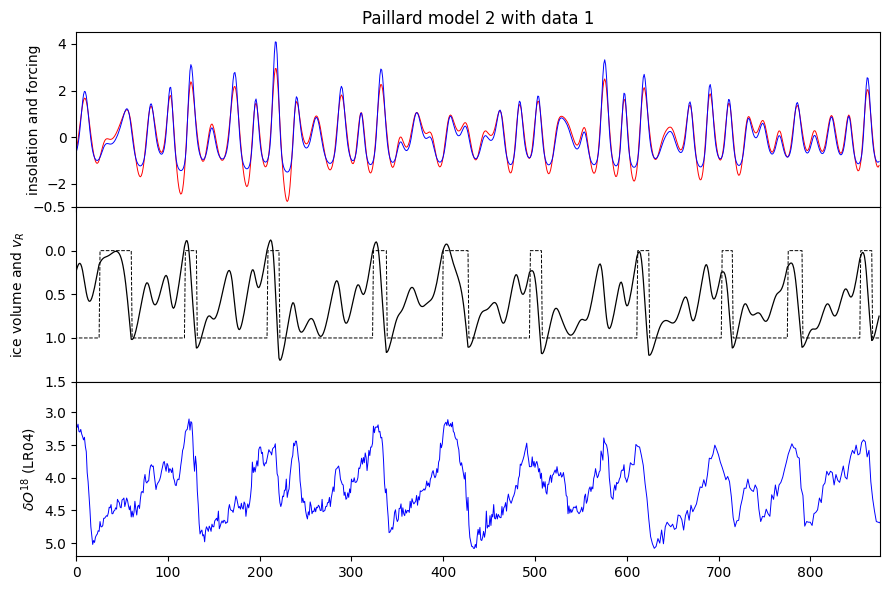

In [164]:
# Calculating and normalizing forcing data
F_data1 = f(inso_data1,a = 1)
F_data1 = normalize(F_data1)

# Setting parameters and running model 2
init_state = 1; v0 = 0.75; vmax = 1; i0=-0.75; i1=0
ice_vol_arr, state_arr = paillard_model2(inso_data1, init_state, v0, vmax, i0, i1)

# Creating array to hold the vRs for the simulation
vR = np.array([1,1,0])
vR_arr = vR[state_arr]

# Plotting with flipped time as is customary in climate physics
gs = dict(hspace=0)
fig, axs = plt.subplots(3, 1, figsize = (9, 6), sharex=True, gridspec_kw = gs)
axs[0].plot(-time_data1, inso_data1, 'r', lw = 0.7, label = 'insolation')
axs[0].plot(-time_data1, F_data1, 'b', lw = 0.7, label = 'forcing')
axs[0].set_xlim(0, len(inso_data1))
axs[0].set_ylim(-3, 4.5)
axs[0].set_ylabel('insolation and forcing')
axs[0].set_title('Paillard model 2 with data 1')

axs[1].plot(-time_data1, vR_arr, 'k--', lw = 0.7, label = '$v_R$')
axs[1].plot(-time_data1, ice_vol_arr, 'k', lw = 0.9, label = 'ice volume')
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].set_ylabel('ice volume and $v_R$')
axs[1].set_xlabel('time since present [kyr]')

axs[2].plot(LR04_time, LR04_iso, 'b', lw=0.7, label='LR04')
axs[2].set_ylim(axs[2].get_ylim()[::-1])
axs[2].set_ylabel('$\delta O^{18}$ (LR04)')

fig.tight_layout()
fig.savefig('paillard_model2_data1.png')

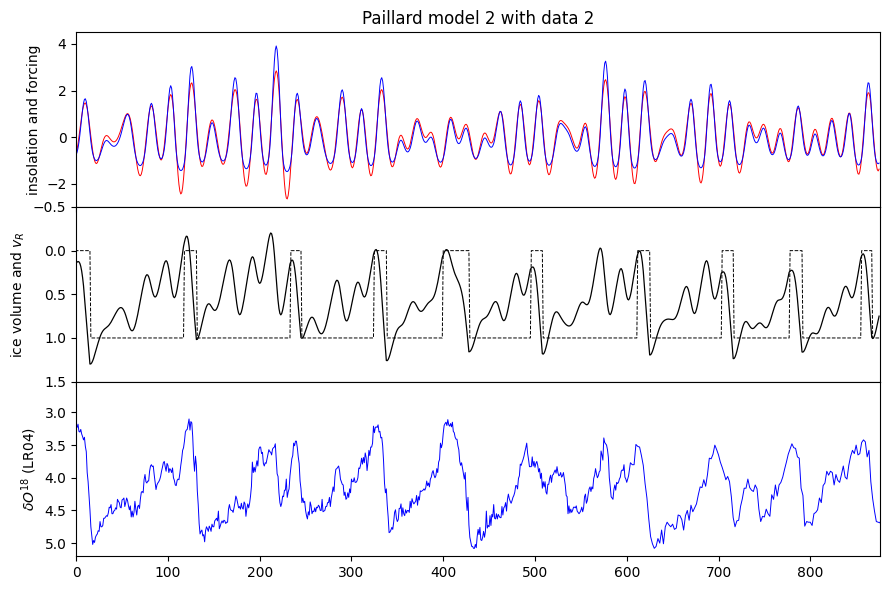

In [165]:
# Calculating and normalizing forcing data
F_data2 = f(inso_data2,a = 1)
F_data2 = normalize(F_data2)

# Setting parameters and running model 2
init_state = 1; v0 = 0.75; vmax = 1; i0=-0.75; i1=0
ice_vol_arr, state_arr = paillard_model2(inso_data2, init_state, v0, vmax, i0, i1)

# Creating array to hold the vRs for the simulation
vR = np.array([1,1,0])
vR_arr = vR[state_arr]

# Plotting with flipped time as is customary in climate physics
gs = dict(hspace=0)
fig, axs = plt.subplots(3, 1, figsize = (9, 6), sharex=True, gridspec_kw = gs)
axs[0].plot(-time_data2, inso_data2, 'r', lw = 0.7, label = 'insolation')
axs[0].plot(-time_data2, F_data2, 'b', lw = 0.7, label = 'forcing')
axs[0].set_xlim(0, len(inso_data2))
axs[0].set_ylim(-3, 4.5)
axs[0].set_ylabel('insolation and forcing')
axs[0].set_title('Paillard model 2 with data 2')

axs[1].plot(-time_data2, vR_arr, 'k--', lw = 0.7, label = '$v_R$')
axs[1].plot(-time_data2, ice_vol_arr, 'k', lw = 0.9, label = 'ice volume')
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].set_ylabel('ice volume and $v_R$')
axs[1].set_xlabel('time since present [kyr]')

axs[2].plot(LR04_time, LR04_iso, 'b', lw=0.7, label='LR04')
axs[2].set_ylim(axs[2].get_ylim()[::-1])
axs[2].set_ylabel('$\delta O^{18}$ (LR04)')

fig.tight_layout()
fig.savefig('paillard_model2_data2.png')

In [166]:
def paillard_model3(inso_data, init_state, v0, Vmax, i0, i1):
    τF = 28
    dt = 1
    
    # Array with constants τR and vR for the given climate regime R 
    i_state = np.array([5,  0])
    g_state = np.array([80, 1])
    G_state = np.array([80, 1])
    state_vals = np.array([G_state, g_state, i_state])
    
    # Calculating and normalizing forcing data
    F_data = f(inso_data,a = 1)
    F_data = normalize(F_data)
    
    # Initializing variables for looping
    ice_volume_arr = np.array([v0])
    state_arr = np.array([init_state])
    vp = v0
    old_state = init_state
    t = 0
    for i in range(len(inso_data) - 1): #looping over all but one data point
        τR, vR = state_vals[old_state] #taking regime constants from state_vals array
        # F = f(inso_data[i], a = 1) #calculating forcing
        F = F_data[i]
        dvdt = ice_vol_diff(F, vR, τR, τF, dt)
        v = Euler_step(dvdt, vp, t, dt) #calculating new ice volume
        # v = RK4_step(dvdt, vp, t, dt) #calculating new ice volume
        new_state = update_state_model2(old_state, v, Vmax[i], inso_data[i], i0, i1) #updating climate model state
        
        #appending data
        ice_volume_arr = np.append(ice_volume_arr, v)
        state_arr = np.append(state_arr, new_state)
        
        #Resetting for new loop
        old_state = new_state
        vp = v
        t+=dt
    return ice_volume_arr, state_arr

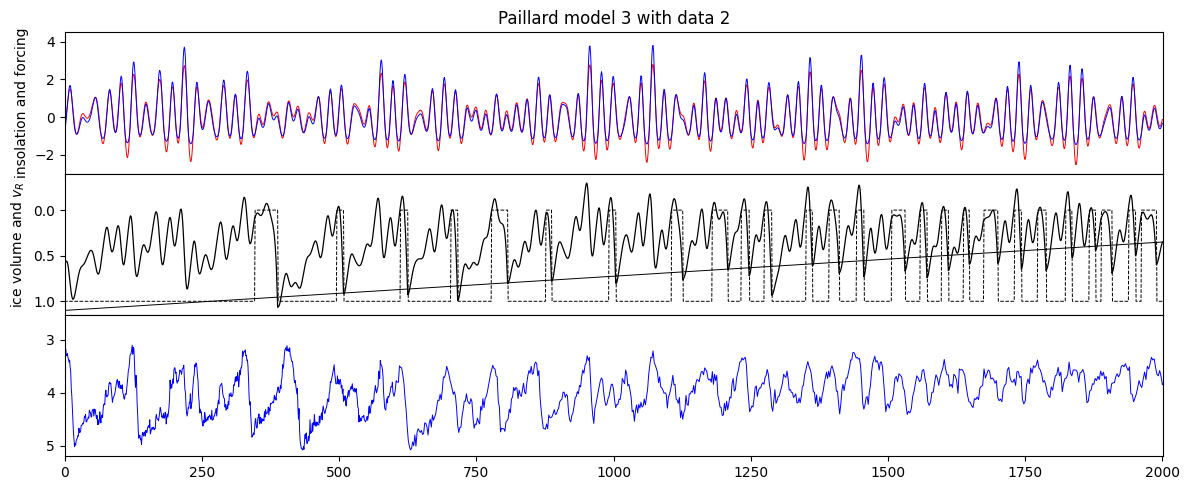

In [167]:
data2 = np.genfromtxt('berger_orbital_data.txt', skip_header=2)[::-1]
time_data2 = data2[:, 0]
ecce_data2 = data2[:, 1]
obli_data2 = data2[:, 3]    
prec_data2 = data2[:, 4]
inso_data2 = data2[:, 5]

S3 = slice(3000, 5001) # slice the data from 2 Myrs ago until present
time_data3 = time_data2[S3]; inso_data3 = inso_data2[S3]; ecce_data3 = ecce_data2[S3]; obli_data3 = obli_data2[S3]; prec_data3 = prec_data2[S3]

# Adding linear trend to insolation
for i in range(len(inso_data3)):
    inso_data3[i] += i * 0.003

# Normalizing insolation data
inso_data3 = normalize(inso_data3)

# Calculating and normalizing forcing data
F_data3 = f(inso_data3, a = 1)
F_data3 = normalize(F_data3)

def vmax_t(t, vmax0 = 0.35):
    a = 0.0003 #W m^-2 kyr^-1
    return vmax0 + a*(2000 + t)

Vmax = np.linspace(0.35, 1.1, len(time_data3))

init_state = 1; v0 = 0.35; i0=-0.75; i1=0
ice_vol_arr, state_arr = paillard_model3(inso_data3, init_state, v0, Vmax, i0, i1)

# Creating array to hold the vRs for the simulation
vR = np.array([1,1,0])
vR_arr = vR[state_arr]

# Plotting with flipped time as is customary in climate physics
gs = dict(hspace=0)
fig, axs = plt.subplots(3, 1, figsize = (12, 5), sharex=True, gridspec_kw = gs)
axs[0].plot(-time_data3, inso_data3, 'r', lw = 0.7, label = 'insolation')
axs[0].plot(-time_data3, F_data3, 'b', lw = 0.7, label = 'forcing')
axs[0].set_xlim(0, len(inso_data3))
axs[0].set_ylim(-3, 4.5)
axs[0].set_ylabel('insolation and forcing')
axs[0].set_title('Paillard model 3 with data 2')

axs[1].plot(-time_data3, Vmax, 'k', lw=0.7, label='$v_{max}$')
axs[1].plot(-time_data3, vR_arr, 'k--', lw = 0.7, label = '$v_R$')
axs[1].plot(-time_data3, ice_vol_arr, 'k', lw = 0.9, label = 'ice volume')
axs[1].set_ylim(-0.4, 1.15)
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].set_ylabel('ice volume and $v_R$')
axs[1].set_xlabel('time since present [kyr]')

axs[2].plot(LR04_time, LR04_iso, 'b', lw=0.7, label='LR04')
axs[2].set_ylim(axs[2].get_ylim()[::-1])

# fig.legend()
fig.tight_layout()
fig.savefig('paillard_model3.png')

In [168]:
from scipy import signal

sig1 = LR04_norm
sig2 = ice_vol_arr
widths = np.arange(1, 500)
cwtmatr = signal.cwt(sig1, signal.ricker, widths)

cwtmatr_yflip = np.flipud(cwtmatr)
plt.imshow(cwtmatr_yflip, extent=[-1, 1, 1, 500], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

NameError: name 'LR04_norm' is not defined

[1 4] {'peak_heights': array([6.57810344, 9.09326325])}


(0.0, 0.4)

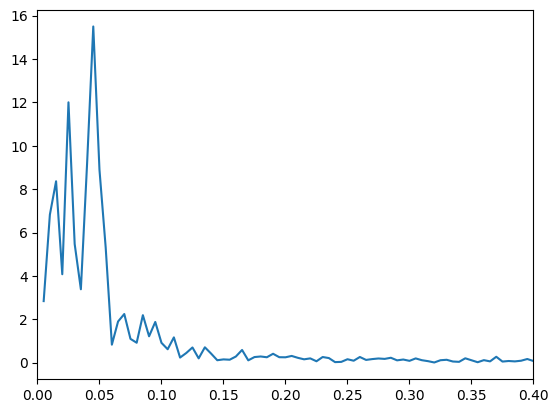

In [ ]:
import scipy as sp

data = ice_vol_arr[:200]

FFT = sp.fft.fft(data)
FFT = FFT[range(int(len(FFT)/2))]
FFT = FFT[1:]
freq = sp.fft.fftfreq(len(data), d=1)
freq = freq[range(int(len(freq)/2))]
freq = freq[1:]

peaks = sp.signal.find_peaks(FFT, height = 4)

print(peaks[0], peaks[1])

plt.plot(freq, np.abs(FFT))

plt.xlim(0, 0.4)